In [89]:
import os

# To avoid memory leak issues with KMeans
os.environ["OMP_NUM_THREADS"] = "2"

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from mlxtend.frequent_patterns import apriori, association_rules

from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from sqlalchemy import create_engine
from urllib.parse import quote


In [92]:
# connection parameters
server = 'localhost'
database = 'BritishAirwaysDB'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
connection_string = f"mssql+pyodbc:///?odbc_connect={quote(f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')}"

try:
    # Establish a connection using pyodbc
    connection = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
    print("Connected successfully to the database.")

    # Execute a simple query to ensure everything is working
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    if row:
        print("Database version:", row[0])

except pyodbc.Error as e:
    print("Error in connection:", e)

finally:
    # Close the connection when established
    if 'connection' in locals() and connection:
        connection.close()

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Query the table
query = "SELECT * FROM MLData"
OpenFile = pd.read_sql(query, engine)


Connected successfully to the database.
Database version: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home Single Language 10.0 <X64> (Build 26100: ) (Hypervisor)



In [95]:

# Show First ten
data = OpenFile
FirstTen = data.head(4)
FirstTen

,FlightID,Origin,Destination,Routes,DateFlown,TravellerType,SeatType,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,ValueForMoney,RecommendedService,ReviewTitle,Review,RatingValue
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,Couple Leisure,Economy Class,1.0,3.0,1.0,0.0,2.0,2.0,no,Not the best customer service,✅ Trip Verified | Not the best customer serv...,1.0
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,Business,Business Class,2.0,1.0,1.0,1.0,2.0,3.0,no,Worst business class experience,✅ Trip Verified | Worst business class experie...,2.0
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,Business,Economy Class,1.0,1.0,3.0,0.0,3.0,3.0,no,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,3.0
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,no,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,1.0


In [75]:
# Feature Engineering

In [100]:
# Transform categorical features
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first column to avoid multicollinearity
encoded_features = encoder.fit_transform(data[['TravellerType', 'SeatType']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['TravellerType', 'SeatType']))


# Combine encoded features with the original data
data = pd.concat([data, encoded_df], axis=1)

# Drop the original categorical columns from the original DataFrame
data = data.drop(columns=['TravellerType', 'SeatType'])

In [102]:
# Create new features
data['AverageServiceRating'] = data[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService']].mean(axis=1)
data['TotalComplaints'] = data[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney']].lt(3).sum(axis=1)

In [104]:
# OneHotEncoder
label_encoder = LabelEncoder()
data['RecommendedService'] = label_encoder.fit_transform(data['RecommendedService'])
data.head(10)

,FlightID,Origin,Destination,Routes,DateFlown,SeatComfort,CabinStaffService,FoodAndBeverages,InflightEntertainment,GroundService,...,Review,RatingValue,TravellerType_Couple Leisure,TravellerType_Family Leisure,TravellerType_Solo Leisure,SeatType_Economy Class,SeatType_First Class,SeatType_Premium Economy,AverageServiceRating,TotalComplaints
0,334,Monrovia,Washington,Monrovia to Washington via Addas Ababa,2025-01-01,1.0,3.0,1.0,0.0,2.0,...,✅ Trip Verified | Not the best customer serv...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.4,5
1,55,Addis Ababa,Toronto,Addis Ababa to Toronto via Rome,2025-01-01,2.0,1.0,1.0,1.0,2.0,...,✅ Trip Verified | Worst business class experie...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,5
2,49,Addis Ababa,Nairobi,Addis Ababa to Nairobi,2024-12-01,1.0,1.0,3.0,0.0,3.0,...,✅ Trip Verified | Towards the end of the fli...,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.6,3
3,178,Dubai,Zanzibar,Dubai to Zanzibar via Ethiopia,2024-12-01,1.0,1.0,1.0,1.0,1.0,...,✅ Trip Verified | Worst service ever. Beside d...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,6
4,205,Harar,Addis Ababa,Harar to Addis Ababa,2024-08-01,3.0,4.0,2.0,1.0,2.0,...,Not Verified | This airline is NEVER on time. ...,3.0,0.0,0.0,1.0,1.0,0.0,0.0,2.4,4
5,312,London,Nairobi,London to Nairobi via Addis Ababa,2024-07-01,3.0,1.0,1.0,1.0,1.0,...,Not Verified | They did not load my luggage de...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.4,5
6,424,Washington IAD,Johannesburg,Washington IAD to Johannesburg,2024-12-01,2.0,2.0,1.0,3.0,1.0,...,✅ Trip Verified | My recent journey from Was...,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.8,5
7,59,Addis Ababa,Washington,Addis Ababa to Washington via Lome,2024-11-01,2.0,2.0,1.0,1.0,2.0,...,✅ Trip Verified | I just landed from an Ethi...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.6,6
8,129,Cape Town,Gatwick,Cape Town to Gatwick via Addis Ababa,2024-07-01,1.0,1.0,1.0,1.0,1.0,...,✅ Trip Verified | On their website they claim...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6
9,266,Lagos,Addis Ababa,Lagos to Addis Ababa,2024-03-01,4.0,5.0,5.0,4.0,5.0,...,✅ Trip Verified | I would like to express my ...,9.0,0.0,0.0,0.0,1.0,0.0,0.0,4.6,0


In [110]:
# Feature Engineering: to improve the quality of your data for clustering, pattern identification, and predictive modeling
# Normalize/Standardize our data

scaler = StandardScaler()
numerical_features = ['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney', 'AverageServiceRating', 'TotalComplaints']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [ ]:
# Clustering for Pattern Identification

In [112]:
# Select Features for Clustering
X = data[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney', 'AverageServiceRating', 'TotalComplaints'] + list(encoded_df.columns)]

In [114]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

In [ ]:
# Pairplot for Service Comparison

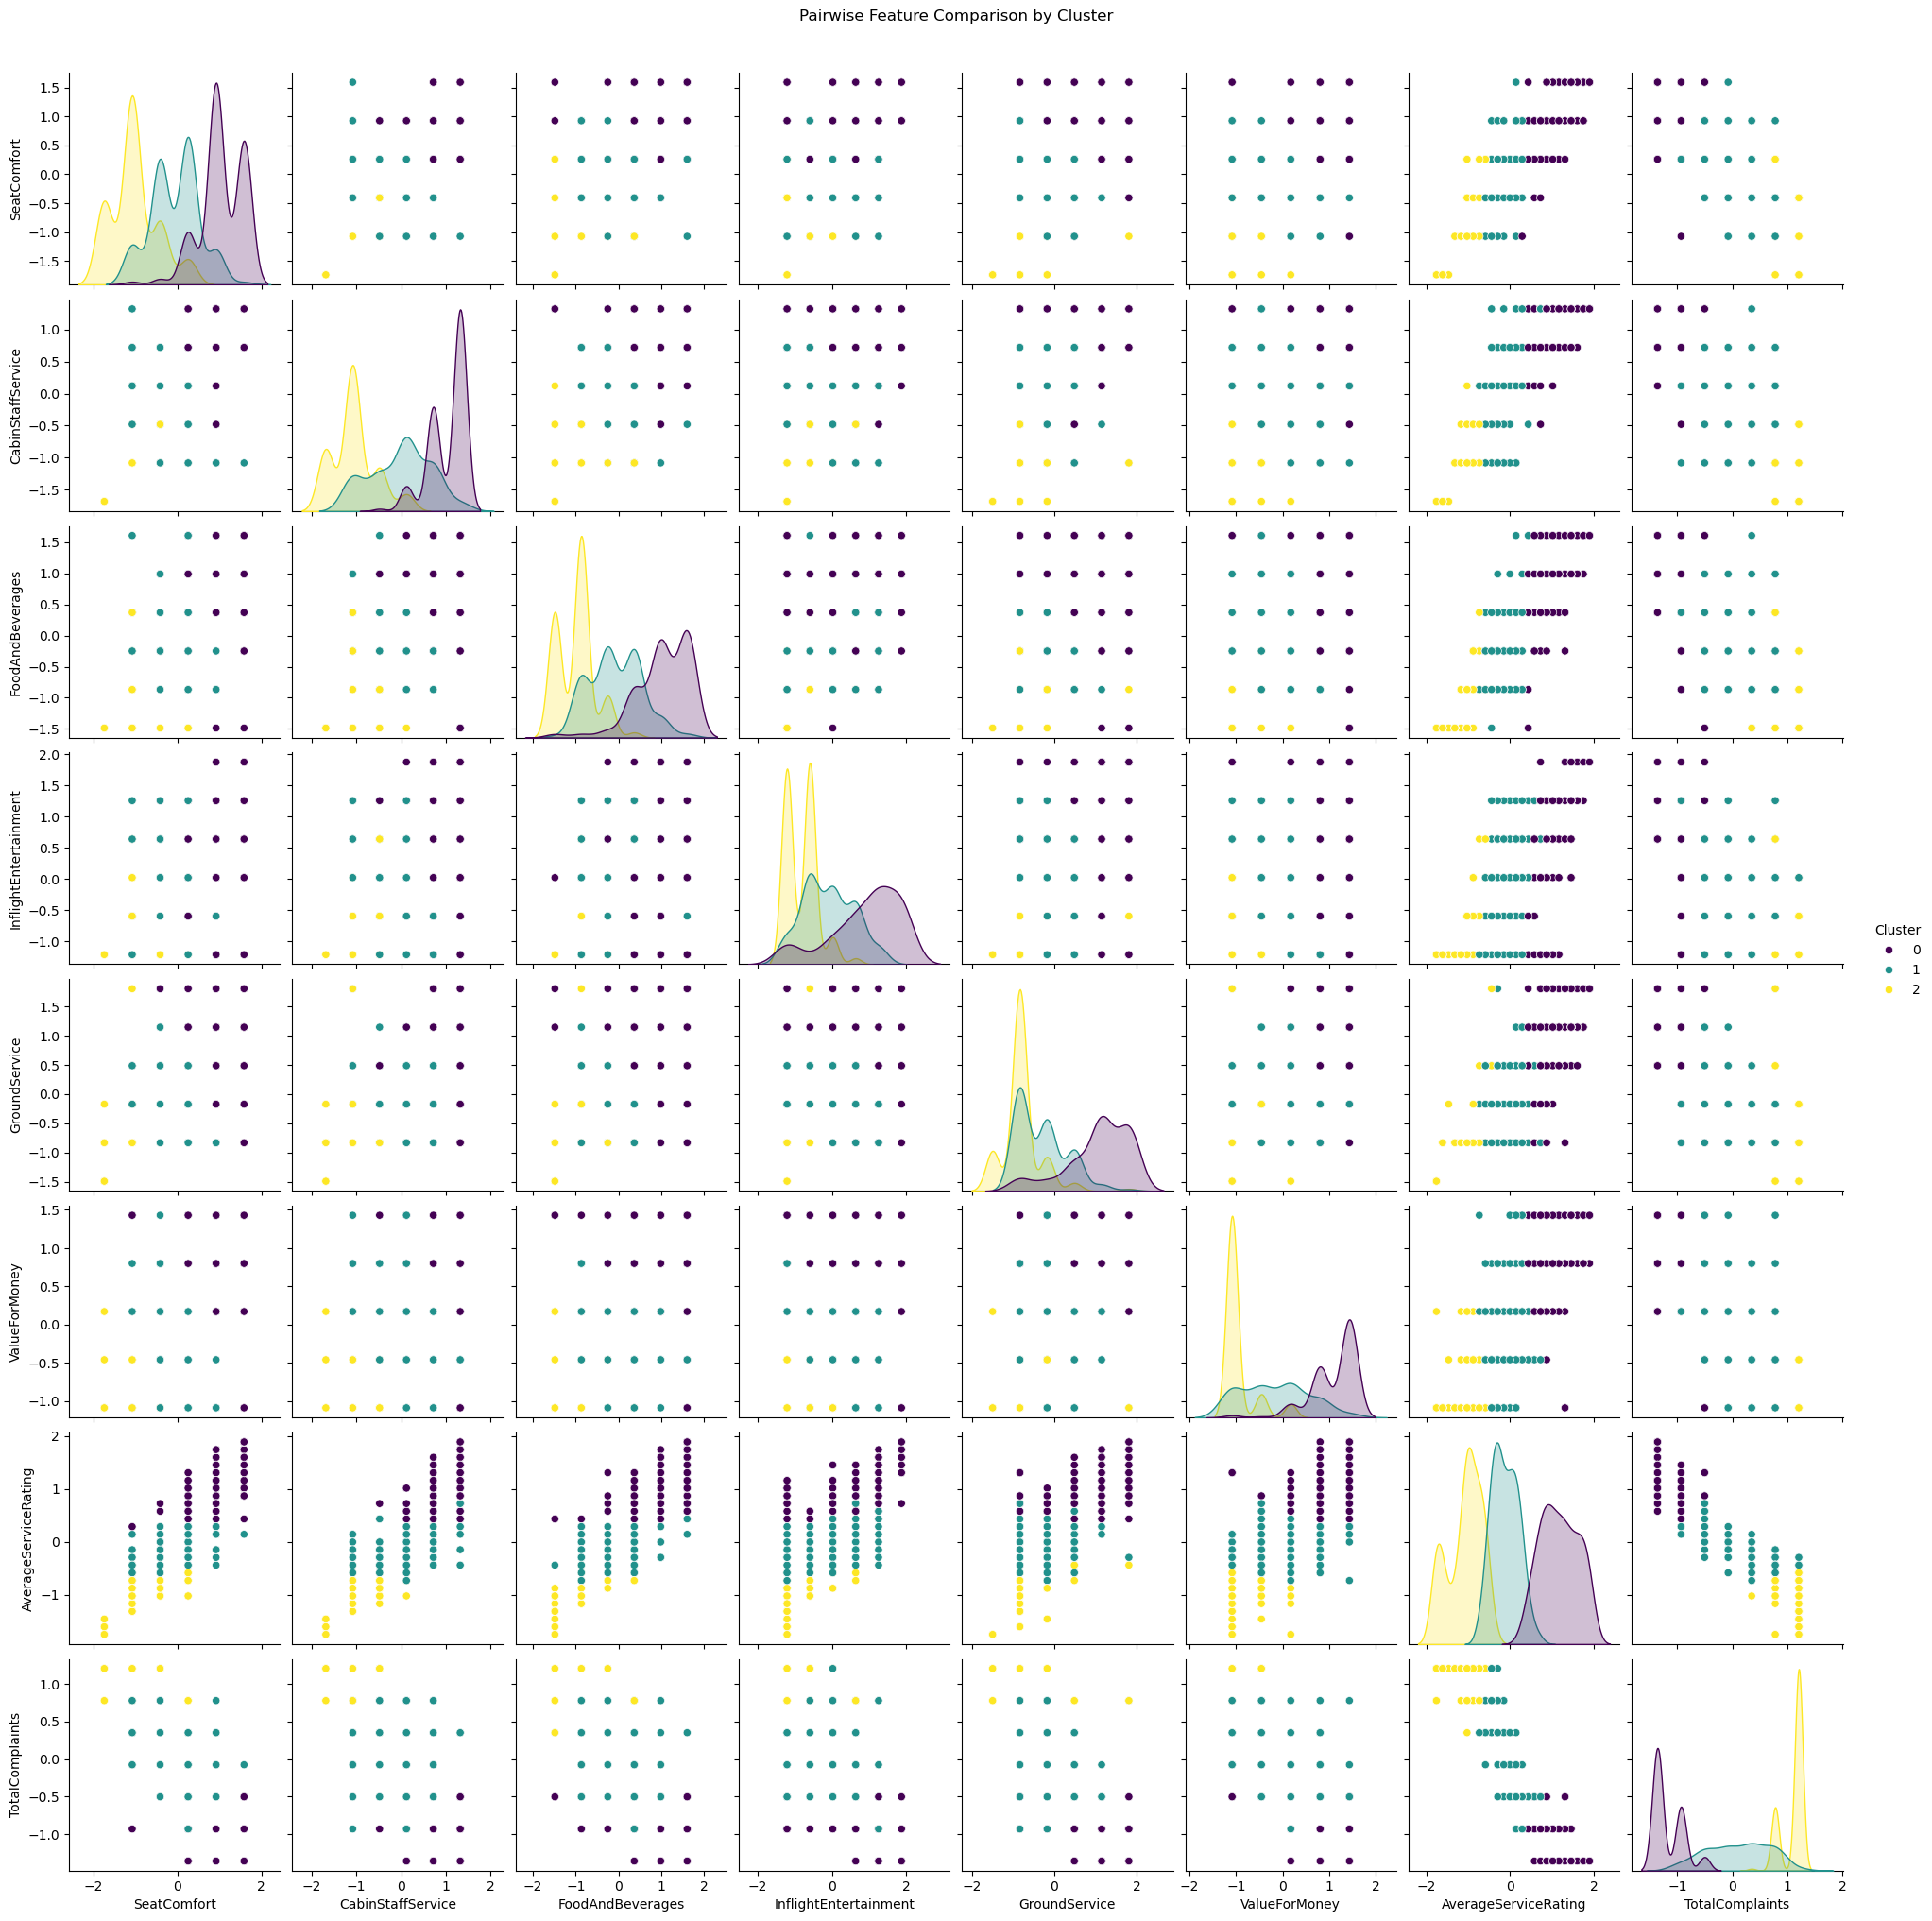

In [116]:
sns.pairplot(data, vars=['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney', 'AverageServiceRating', 'TotalComplaints'], hue='Cluster', palette='viridis')
plt.suptitle("Pairwise Feature Comparison by Cluster", y=1.02)
plt.show()

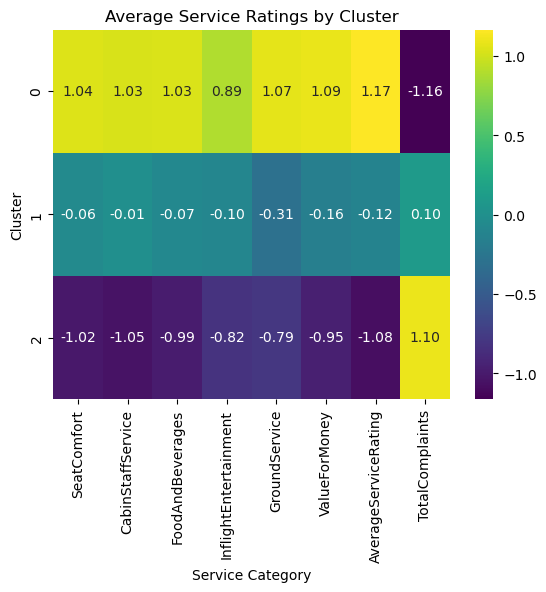

In [118]:
# Heatmap for Average Ratings by Cluster

cluster_avg = data.groupby('Cluster')[['SeatComfort', 'CabinStaffService', 'FoodAndBeverages', 'InflightEntertainment', 'GroundService', 'ValueForMoney', 'AverageServiceRating', 'TotalComplaints']].mean()
sns.heatmap(cluster_avg, annot=True, cmap='viridis', fmt=".2f")
plt.title("Average Service Ratings by Cluster")
plt.xlabel("Service Category")
plt.ylabel("Cluster")
plt.show()

C:\Users\osen1\AppData\Local\Temp\ipykernel_15232\848552194.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=data, palette='viridis')


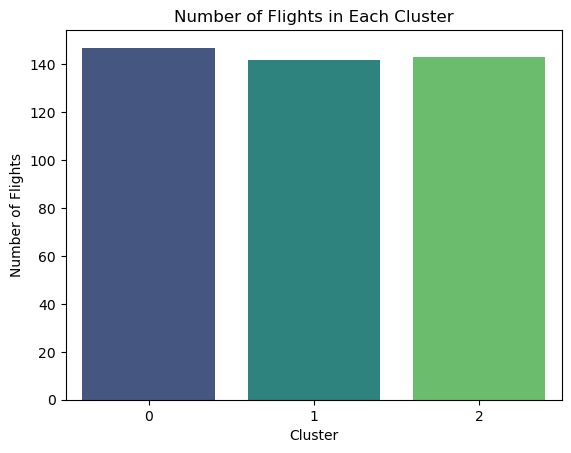

In [120]:
sns.countplot(x='Cluster', data=data, palette='viridis')
plt.title("Number of Flights in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Flights")
plt.show()